# Transform output probabilities to different class base rates
This notebook illustrates how to transform classifier output probabilities (assuming they are well calibrated) to reflect different class base rates as used in the training.

For a binary classification problem, the output probability can be interpreted as a posterior probability of a true event, given the observables/inputs $x$:

\begin{equation}
p_1 = P(1\mid x) = \frac{P(x\mid 1)P(1)}{P(x\mid 1)P(1)+P(x\mid 0)P(0)} = \frac{L_1 f_1}{L_1 f_1 + L_0 f_0} = \frac{f_1}{f_1 + \frac{L_0}{L_1} f_0}
\label{eq:p1} \tag{1}
\end{equation}

with the Likelihood of $x$ given true or false events ($L_1$ and $L_0$) and the prior rates $f_1$ and $f_0$ of true and false events. Since the Likelihood is independent of the prior rates, we can solve equation $\eqref{eq:p1}$ by $\frac{L_0}{L_1}$ and get for our transformed probability $p_1^\prime$ with new prior rates $f_0^\prime$ and $f_1^\prime$

\begin{equation}
p_1^\prime = \frac{f_1^\prime}{f_1^\prime + (\frac{1}{p_1}-1)f_0^\prime\frac{f_1}{f_0}} = \frac{1}{1+(\frac{1}{p_1}-1)\frac{r}{r^\prime}} \qquad \text{with} \quad r:=\frac{f_0}{f_1}
\end{equation}

In [1]:
def transform(p, r_new, r_old=1):
    return 1. / (1. + (1. / p - 1) * r_new / r_old)

In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
x = np.concatenate(
    [
        np.random.normal(loc=-1, size=10000),
        np.random.normal(loc=1, size=10000),
    ]
)
y = np.concatenate([np.zeros(10000), np.ones(10000)])
shuf = np.random.permutation(len(x))
x = x[shuf]
y = y[shuf]

In [4]:
def plot_scores(x, y, opts=dict(bins=100, range=(0, 1), alpha=0.5), fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(x[y==0], **opts)
    ax.hist(x[y==1], **opts)
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f86c9e599b0>)

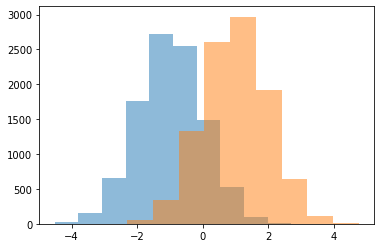

In [5]:
plot_scores(x, y, opts=dict(alpha=0.5))

In [6]:
model = keras.models.Sequential([keras.layers.Dense(1, activation="sigmoid", input_shape=(1,))])
model.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss="binary_crossentropy")

W0402 10:13:18.536813 140218082109248 deprecation.py:506] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0402 10:13:18.581198 140218082109248 deprecation.py:323] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# fit assuming 50:50 (r = 1) 
model.fit(x, y, epochs=5)

Epoch 1/5
20000/20000 [==============================] - 1s 64us/sample - loss: 0.3605
Epoch 2/5
20000/20000 [==============================] - 1s 49us/sample - loss: 0.3612
Epoch 3/5
20000/20000 [==============================] - 1s 48us/sample - loss: 0.3616
Epoch 4/5
20000/20000 [==============================] - 1s 48us/sample - loss: 0.3608
Epoch 5/5
20000/20000 [==============================] - 1s 49us/sample - loss: 0.3609


In [8]:
scores = model.predict(x)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f86c8fd01d0>)

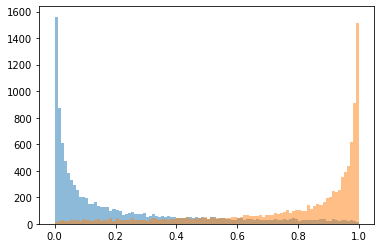

In [9]:
plot_scores(scores, y)

In [10]:
# transform to r = 1000
scores_transf = transform(scores, r_new=1000, r_old=1)

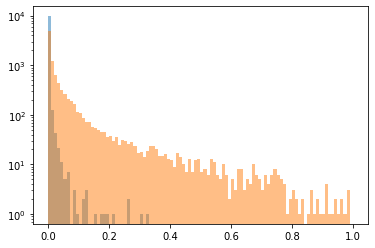

In [11]:
fig, ax = plot_scores(scores_transf, y)
ax.set_yscale("log")

In [12]:
model2 = keras.models.Sequential([keras.layers.Dense(1, activation="sigmoid", input_shape=(1,))])
model2.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss="binary_crossentropy")

In [13]:
# now train a model assuming r = 1000 (with class weights)
weights = np.ones(len(x))
weights[y==0] = 1000
weights /= weights.mean()
model2.fit(x, y, sample_weight=weights, epochs=5)

Epoch 1/5
20000/20000 [==============================] - 1s 75us/sample - loss: 0.0197
Epoch 2/5
20000/20000 [==============================] - 1s 61us/sample - loss: 0.0061
Epoch 3/5
20000/20000 [==============================] - 1s 53us/sample - loss: 0.0060
Epoch 4/5
20000/20000 [==============================] - 1s 52us/sample - loss: 0.0060
Epoch 5/5
20000/20000 [==============================] - 1s 52us/sample - loss: 0.0060


In [14]:
scores_classw = model2.predict(x)

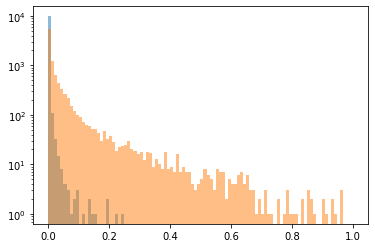

In [15]:
fig, ax = plot_scores(scores_classw, y)
ax.set_yscale("log")

In [16]:
# transform back to r = 1
scores_classw_invtransf = transform(scores_classw, r_new=1, r_old=1000)

/home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


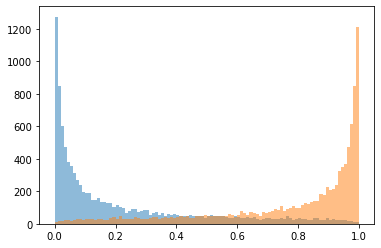

In [17]:
fig, ax = plot_scores(scores_classw_invtransf, y)